In [1]:
import warnings
import sys
sys.path.insert(0, '../src')

In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/10884668/two-sample-kolmogorov-smirnov-test-in-python-scipy
from scipy.stats import ks_2samp

In [3]:
from felix_ml_tools import macgyver as mg

In [4]:
from utils import *
import config

In [5]:
warnings.filterwarnings('ignore')

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline 

# Hypothesis

Análise comparativa entre as cidades mais violentas e menos violentas

## Hypothesis 1

O nível de IDH é inversamente proporcional ao nível de violência nas cidades

### Hypothesis 1.3

Famílias em cidades com alto grau de desemprego têm baixa renda / menor poder aquisitivo (ex: renda menor salário mínimo), o que faz fomentar alternativas ilegais para aumentar a renda e, consequentemente, conflitos com a polícia e a taxa de homicídios

- Hypothesis (1.3.1): Quanto maior o grau de desemprego para jovens e adultos, maior o número de trabalhos ilegais e informais area km2 em relacao homicidios

Principais questões:
- É possível indentifiar as cidades mais violentas e menos violentas?
- Existe relação entre as características de diversaso fontes e as cidades mais/menos violentas?
- Existe diferença na população entre cidades mais/menos violentas?
- Existe diferença na taxa de homicidios entre cidades mais/menos violentas?
- Existe diferença na taxa de homicidios de pessoas com/sem ocupação entre cidades mais/menos violentas?
- Existe diferença na taxa de empregabilidade (formal/CLT) entre cidades mais/menos violentas?
- Existe diferença no PIB per capita entre cidades mais/menos violentas?
- Existe diferença nas atividades economicas entre cidades mais/menos violentas? (cnae, cbo)

# Intro

Ingestão de recorte de dados conforme população-alvo

In [6]:
municipio_features_slice = pd.read_parquet('../data/handled/municipio_features_slice.parquet')

inspect(municipio_features_slice);

shape: (594, 47)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo', 'municipioCodigo6d', 'populacaoEstimada', 'faixaPopulacaoEstimada', 'valorBrutoAgropecuraria1000', 'valorBrutoIndustria1000', 'valorBrutoServicos1000', 'valorBrutoUtilidade1000', 'valorBruto1000', 'impostosProdutos1000', 'pib1000', 'pibPerCapita', 'atividadeMaisRelevanteValorBruto1', 'atividadeMaisRelevanteValorBruto2', 'atividadeMaisRelevanteValorBruto3', 'totalFuncionarios', 'qtHomicidios', 'qtHomicidiosFeminino', 'qtHomicidiosMasculino', 'qtHomicidiosComAssistmed', 'qtHomicidiosSemAssistmed', 'qtHomicidiosSemOcupacao', 'qtHomicidiosComOcupacao', 'ufQtHomicidios', 'ufQtHomicidiosFeminino', 'ufQtHomicidiosMasculino', 'ufQtHomicidiosComAssistmed', 'ufQtHomicidiosSemAssistmed', 'ufQtHomicidiosSemOcupacao', 'ufQtHomicidiosComOcupacao', 'part_homicidios_uf', 'part_homicidios_sem_ocupacao', 'part_homicidios_com_ocupacao', 'part_funcionarios_populacao', 'part_funcionarios_populaca

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k,nivelHomicidiosPopulacao1k
451,MA,21,Maranhão,Afonso Cunha,AFONSO CUNHA,2100105,210010,6524.000,0:10000,10356,1834,9133,22418,43742,1236,44978,6935,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,240.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,0.037,36.787,367.872,3678.725,NaN,NaN,NaN,NaN,NaN
455,MA,21,Maranhão,Altamira do Maranhão,ALTAMIRA DO MARANHAO,2100402,210040,8128.000,0:10000,14451,1872,11252,27165,54740,1747,56487,7000,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",226.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,0.028,27.805,278.051,2780.512,NaN,NaN,NaN,NaN,NaN
459,MA,21,Maranhão,Amapá do Maranhão,AMAPA DO MARANHAO,2100550,210055,6962.000,0:10000,8458,1505,14601,22173,46736,2431,49167,7131,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",257.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,0.037,36.915,369.147,3691.468,NaN,NaN,NaN,NaN,NaN
472,MA,21,Maranhão,Bacurituba,BACURITUBA,2101350,210135,5644.000,0:10000,3901,1329,8626,19978,33834,1354,35188,6313,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",250.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,0.044,44.295,442.948,4429.483,NaN,NaN,NaN,NaN,NaN
477,MA,21,Maranhão,Belágua,BELAGUA,2101731,210173,7469.000,0:10000,5238,1850,9261,30392,46741,945,47686,6425,"Administração, defesa, educação e saúde públic...",Demais serviços,"Agricultura, inclusive apoio à agricultura e a...",523.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,0.070,70.023,700.228,7002.276,NaN,NaN,NaN,NaN,NaN


## Ranking

Qual municipio com maior quantidade de homicídios em números absolutos?

In [7]:
municipio_features_slice.sort_values(by='qtHomicidios', ascending=False).head(5)

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k,nivelHomicidiosPopulacao1k
1868,BA,29,Bahia,Barro Preto,BARRO PRETO,2903300,290330,5591.000,0:10000,18725,2309,13164,24754,58953,1325,60278,9643,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,482.000,8.000,0.000,8.000,0.000,5.000,8.000,0.000,3501,176,3325,320,2920,1926,1575,0.002,1.000,0.000,0.086,86.210,862.100,8620.998,0.001,1.431,14.309,143.087,muito alto
1655,AL,27,Alagoas,Barra de São Miguel,BARRA DE SAO MIGUEL,2700607,270060,8322.000,0:10000,17478,18697,86954,40157,163286,8461,171747,20444,Demais serviços,"Administração, defesa, educação e saúde públic...",Construção\r,1619.000,7.000,0.000,7.000,0.000,7.000,4.000,3.000,833,25,808,61,747,507,326,0.008,0.571,0.429,0.195,194.545,1945.446,19454.458,0.001,0.841,8.411,84.114,muito alto
1143,RN,24,Rio Grande do Norte,Lagoa d'Anta,LAGOA D ANTA,2406205,240620,6769.000,0:10000,1448,1471,11923,34171,49013,1489,50503,7435,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,297.000,7.000,0.000,7.000,0.000,7.000,5.000,2.000,1031,40,991,81,915,707,324,0.007,0.714,0.286,0.044,43.876,438.765,4387.650,0.001,1.034,10.341,103.413,muito alto
2186,BA,29,Bahia,São José da Vitória,SAO JOSE DA VITORIA,2929354,292935,5657.000,0:10000,3838,2348,16347,23833,46365,2715,49080,8119,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,468.000,6.000,1.000,5.000,0.000,5.000,5.000,1.000,3501,176,3325,320,2920,1926,1575,0.002,0.833,0.167,0.083,82.729,827.294,8272.936,0.001,1.061,10.606,106.063,muito alto
1130,RN,24,Rio Grande do Norte,Jaçanã,JACANA,2405009,240500,9133.000,0:10000,1909,2402,11721,43293,59325,1399,60724,6696,"Administração, defesa, educação e saúde públic...",Demais serviços,Construção\r,316.000,6.000,0.000,6.000,0.000,5.000,5.000,1.000,1031,40,991,81,915,707,324,0.006,0.833,0.167,0.035,34.600,345.998,3459.980,0.001,0.657,6.570,65.696,alto


Qual municipio tem maior taxa de homícios por 1000 habitantes?

In [8]:
municipio_features_slice.sort_values(by='part_homicidios_populacao1k', ascending=False).head(5)

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k,nivelHomicidiosPopulacao1k
1201,RN,24,Rio Grande do Norte,São Bento do Norte,SAO BENTO DO NORTE,2411601,241160,2747.000,0:10000,14125,105138,27958,23290,170510,25877,196387,69005,"Eletricidade e gás, água, esgoto, atividades d...",Indústrias de transformação,Demais serviços\r,534.000,5.000,0.000,5.000,0.000,5.000,5.000,0.000,1031,40,991,81,915,707,324,0.005,1.000,0.000,0.194,194.394,1943.939,19439.388,0.002,1.820,18.202,182.017,muito alto
1868,BA,29,Bahia,Barro Preto,BARRO PRETO,2903300,290330,5591.000,0:10000,18725,2309,13164,24754,58953,1325,60278,9643,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,482.000,8.000,0.000,8.000,0.000,5.000,8.000,0.000,3501,176,3325,320,2920,1926,1575,0.002,1.000,0.000,0.086,86.210,862.100,8620.998,0.001,1.431,14.309,143.087,muito alto
2186,BA,29,Bahia,São José da Vitória,SAO JOSE DA VITORIA,2929354,292935,5657.000,0:10000,3838,2348,16347,23833,46365,2715,49080,8119,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,468.000,6.000,1.000,5.000,0.000,5.000,5.000,1.000,3501,176,3325,320,2920,1926,1575,0.002,0.833,0.167,0.083,82.729,827.294,8272.936,0.001,1.061,10.606,106.063,muito alto
1143,RN,24,Rio Grande do Norte,Lagoa d'Anta,LAGOA D ANTA,2406205,240620,6769.000,0:10000,1448,1471,11923,34171,49013,1489,50503,7435,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,297.000,7.000,0.000,7.000,0.000,7.000,5.000,2.000,1031,40,991,81,915,707,324,0.007,0.714,0.286,0.044,43.876,438.765,4387.650,0.001,1.034,10.341,103.413,muito alto
1733,AL,27,Alagoas,Roteiro,ROTEIRO,2707800,270780,6664.000,0:10000,88454,2417,21460,34167,146499,1163,147662,21798,"Agricultura, inclusive apoio à agricultura e a...","Administração, defesa, educação e saúde públic...","Produção florestal, pesca e aquicultura",643.000,6.000,0.000,6.000,0.000,6.000,4.000,2.000,833,25,808,61,747,507,326,0.007,0.667,0.333,0.096,96.489,964.886,9648.860,0.001,0.900,9.004,90.036,muito alto


## Questões

**É possível indentifiar as cidades mais violentas e menos violentas?**

Para realizar a análise comparativa, iremos considerar as top 10% cidades mais violentas e as 10% cidades menos violentas para criar um conjunto de dados rótulado `municipios_ranking`, que discrimina se uma cidade é violenta ou não:

'top_municipios_mais_violentos'

,uf,nomeMunicipio,populacaoEstimada,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao1k,part_homicidios_populacao1k,nivelHomicidiosPopulacao1k,violento
1201,RN,São Bento do Norte,2747.000,69005,"Eletricidade e gás, água, esgoto, atividades d...",Indústrias de transformação,Demais serviços\r,534.000,1.000,0.000,194.394,1.820,muito alto,True
1868,BA,Barro Preto,5591.000,9643,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,482.000,1.000,0.000,86.210,1.431,muito alto,True
2186,BA,São José da Vitória,5657.000,8119,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,468.000,0.833,0.167,82.729,1.061,muito alto,True
1143,RN,Lagoa d'Anta,6769.000,7435,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,297.000,0.714,0.286,43.876,1.034,muito alto,True
1733,AL,Roteiro,6664.000,21798,"Agricultura, inclusive apoio à agricultura e a...","Administração, defesa, educação e saúde públic...","Produção florestal, pesca e aquicultura",643.000,0.667,0.333,96.489,0.900,muito alto,True


'top_municipios_menos_violentos'

,uf,nomeMunicipio,populacaoEstimada,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao1k,part_homicidios_populacao1k,nivelHomicidiosPopulacao1k,violento
1600,PE,Sairé,9932.000,14360,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,583.000,0.000,1.000,58.699,0.101,muito baixo,False
1875,BA,Bom Jesus da Serra,9880.000,5156,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",415.000,0.000,1.000,42.004,0.101,muito baixo,False
1342,PB,Juru,9867.000,7500,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",429.000,1.000,0.000,43.478,0.101,muito baixo,False
760,PI,Ilha Grande,9426.000,7364,"Administração, defesa, educação e saúde públic...",Demais serviços,"Produção florestal, pesca e aquicultura",442.000,0.000,1.000,46.892,0.106,muito baixo,False
482,MA,Boa Vista do Gurupi,9287.000,6611,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,395.000,1.000,0.000,42.533,0.108,muito baixo,False


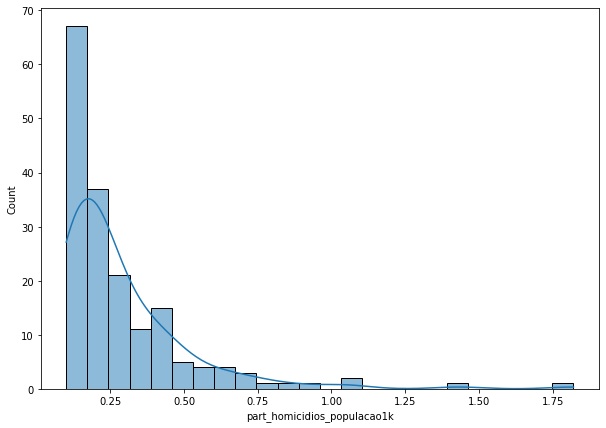

In [9]:
cols_selection = [
    'uf',
    'nomeMunicipio',
    'populacaoEstimada',
    # 'pib1000',
    'pibPerCapita',
    'atividadeMaisRelevanteValorBruto1', 
    'atividadeMaisRelevanteValorBruto2',
    'atividadeMaisRelevanteValorBruto3',
    'totalFuncionarios',
    'part_homicidios_sem_ocupacao',
    'part_homicidios_com_ocupacao',
    'part_funcionarios_populacao1k',
    'part_homicidios_populacao1k',
    'nivelHomicidiosPopulacao1k'
]

municipio_features_slice = (
    municipio_features_slice[cols_selection]
)

rank_size = int(len(municipio_features_slice) * 0.1)

rank_col = 'part_homicidios_populacao1k'

target_col = 'violento'

top_municipios_mais_violentos = rank(
    municipio_features_slice,
    feature_col=rank_col,
    n=rank_size
)

top_municipios_menos_violentos = rank(
    municipio_features_slice,
    feature_col=rank_col,
    n=rank_size,
    ascending=True
)

top_municipios_mais_violentos[target_col] = True
top_municipios_menos_violentos[target_col] = False

municipios_ranking = pd.concat(
    [top_municipios_mais_violentos, top_municipios_menos_violentos],
    axis=0
)

mg.plot_hist(municipio_features_slice, 'part_homicidios_populacao1k')

display('top_municipios_mais_violentos', top_municipios_mais_violentos.head(5))
display('top_municipios_menos_violentos', top_municipios_menos_violentos.head(5))

**Existe relação entre as características de diversaso fontes e as cidades mais/menos violentas?**

,x,ppscore,is_valid_score,metric
167,part_homicidios_populacao1k,1.000,True,weighted F1
181,nivelHomicidiosPopulacao1k,1.000,True,weighted F1
41,populacaoEstimada,0.316,True,weighted F1
125,part_homicidios_sem_ocupacao,0.263,True,weighted F1
139,part_homicidios_com_ocupacao,0.263,True,weighted F1
153,part_funcionarios_populacao1k,0.183,True,weighted F1
13,uf,0.182,True,weighted F1
97,atividadeMaisRelevanteValorBruto3,0.173,True,weighted F1
55,pibPerCapita,0.061,True,weighted F1
27,nomeMunicipio,0.000,True,None


<AxesSubplot:title={'center':'PPS matrix (%)'}, xlabel='feature', ylabel='target'>

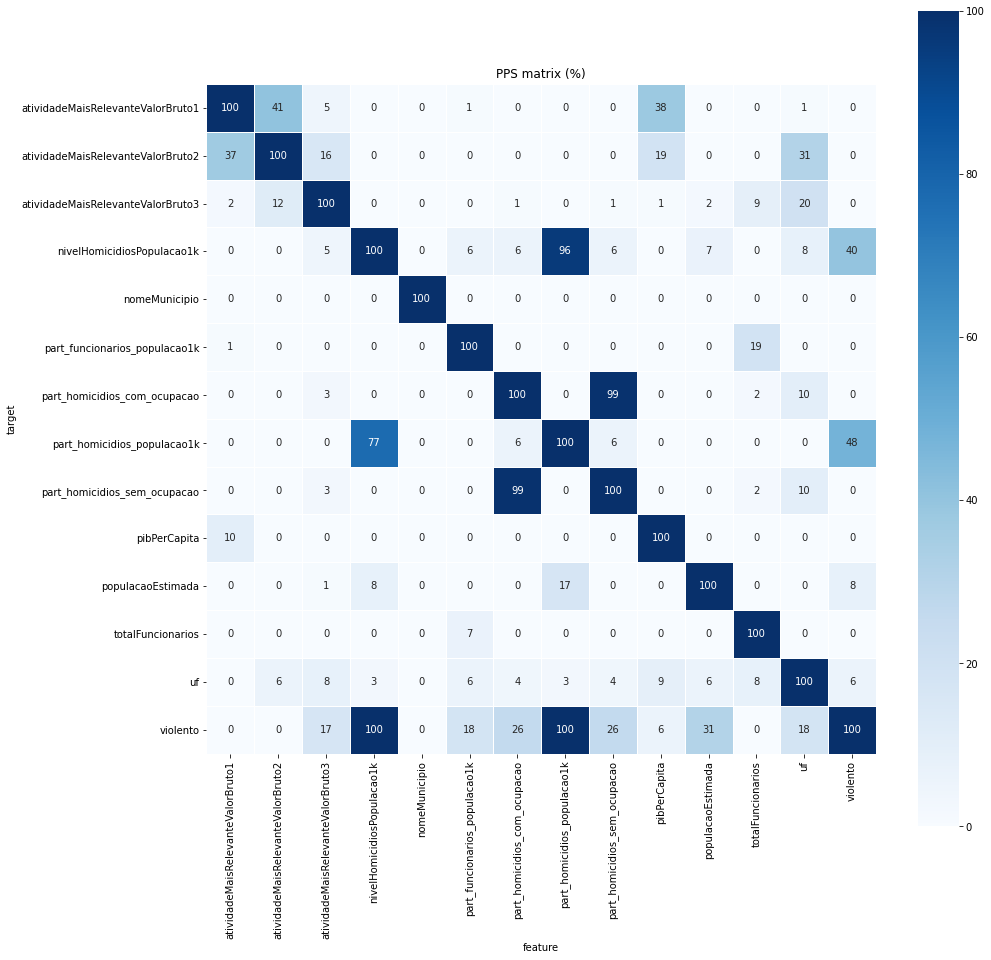

In [10]:
ppscores = mg.get_ppscore_matrix(municipios_ranking)

feature_relevante = mg.get_ppscore_feature_relevante(ppscores, target_variable=target_col, cols=cols_selection)

display(feature_relevante)

mg.plot_ppscore_heatmap(ppscores, figsize=(15,15))

interval columns not set, guessing: ['populacaoEstimada', 'pibPerCapita', 'totalFuncionarios', 'part_homicidios_sem_ocupacao', 'part_homicidios_com_ocupacao', 'part_funcionarios_populacao1k', 'part_homicidios_populacao1k']


Text(113.09374999999999, 0.5, 'target')

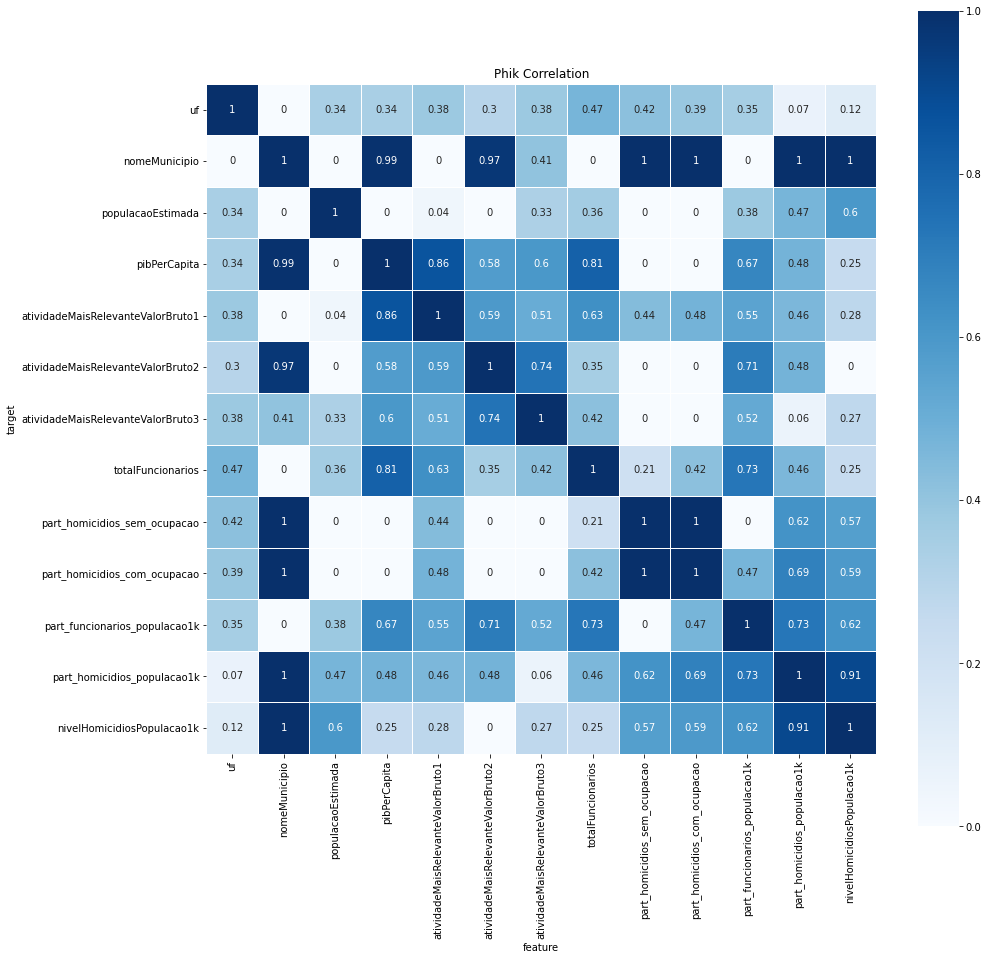

In [11]:
from phik.report import plot_correlation_matrix

# tst = municipios_ranking.phik_matrix()
tst = municipio_features_slice.phik_matrix()

fig, ax = plt.subplots(figsize=(15,15))

ax = sns.heatmap(
    tst.apply(lambda x: x.round(2)),
    cmap="Blues",
    linewidths=0.5,
    square=True,
    annot=True,
    fmt='g'
)

ax.set_title("Phik Correlation")
ax.set_xlabel("feature")
ax.set_ylabel("target")

interval columns not set, guessing: ['populacaoEstimada', 'pibPerCapita', 'totalFuncionarios', 'part_homicidios_sem_ocupacao', 'part_homicidios_com_ocupacao', 'part_funcionarios_populacao1k', 'part_homicidios_populacao1k']


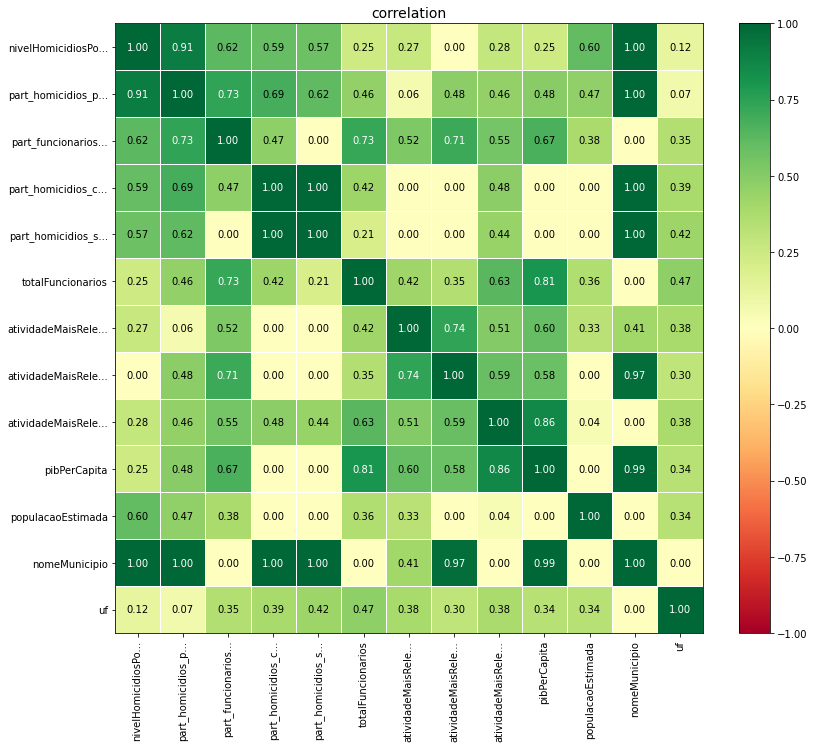

In [12]:
tst = municipio_features_slice.phik_matrix()

plot_correlation_matrix(
    tst.values,
    x_labels=tst.columns,
    y_labels=tst.index,
    #color_map='Blues',
    figsize=(12,10.5)
)

**Existe diferença na população entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 6057.745762711865
	CI (5495.932627118644, 6611.715677966102)
top_municipios_menos_violentos kpis:
	avg 7892.983050847458
	CI (7624.30720338983, 8149.56186440678)
KS-test KstestResult(statistic=0.4745762711864407, pvalue=2.2193961234991357e-06)


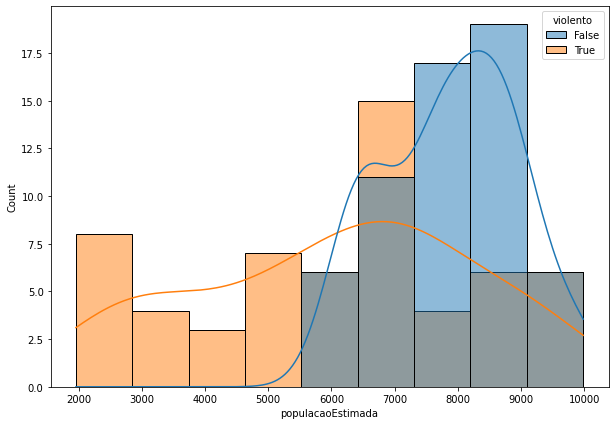

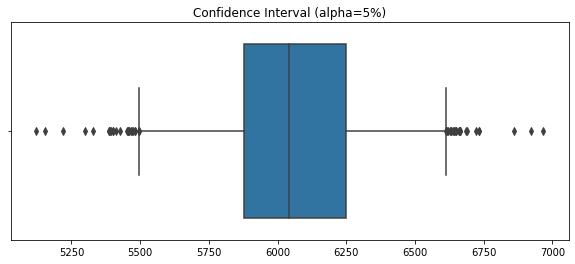

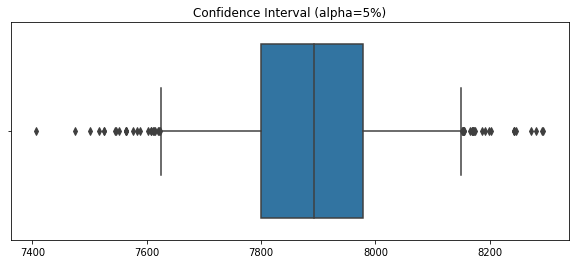

In [13]:
explainable_col = 'populacaoEstimada'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Considerando faixa populacional selecionada, existe diferença na população entre cidades mais/menos violentas
- As ciades mais violentas tem menor número de pessoas em relação

**Existe diferença na taxa de homicídios entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 0.5153628275156988
	CI (0.44694896839888143, 0.5910287991580234)
top_municipios_menos_violentos kpis:
	avg 0.12897705576948115
	CI (0.12472415364433752, 0.1336221624848189)
KS-test KstestResult(statistic=1.0, pvalue=8.211293089808295e-35)


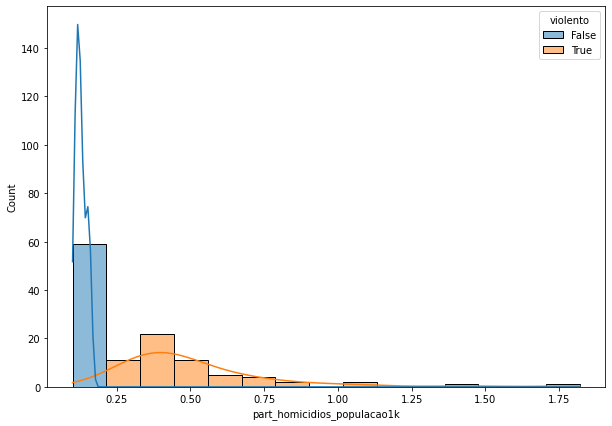

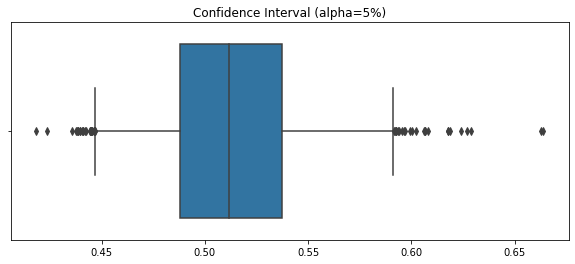

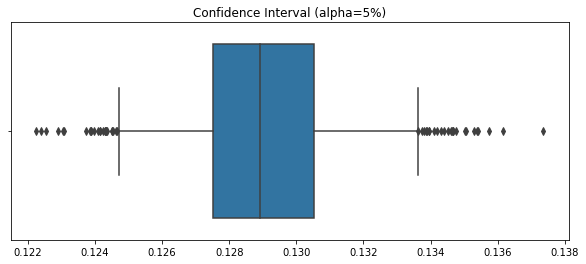

In [14]:
explainable_col = 'part_homicidios_populacao1k'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença na taxa de homicídios entre cidades mais/menos violentas
- Em algumas cidades mais violentas, a quantidade de homicídios chega a 2 para cada mil habitantes
- Em relação as cidades menos violentas, a quantidade de homicídios é quase zero

**Existe diferença na taxa de homicídios de pessoas com/sem ocupação entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 0.49967715899919285
	CI (0.3994975786924939, 0.6082647296206618)
top_municipios_menos_violentos kpis:
	avg 0.4915254237288136
	CI (0.3728813559322034, 0.6101694915254238)
KS-test KstestResult(statistic=0.22033898305084745, pvalue=0.1141436599629735)


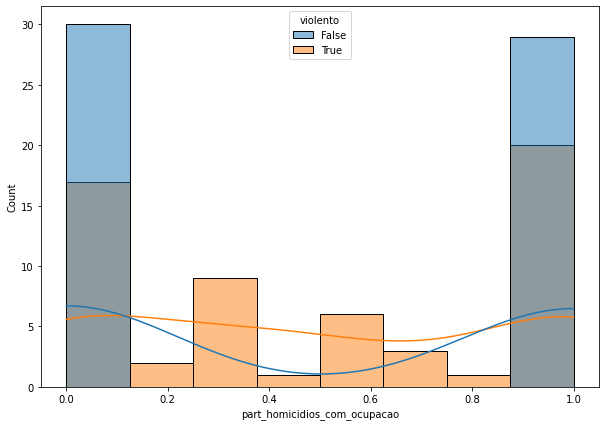

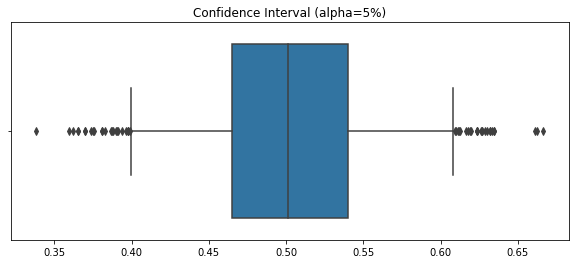

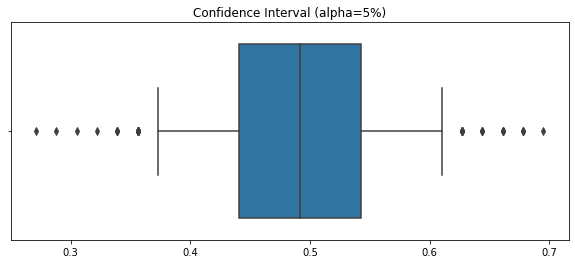

In [15]:
explainable_col = 'part_homicidios_com_ocupacao'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Não existe diferença de taxa de homicídios de pessoas com/sem ocupação entre cidades mais/menos violentas

**Existe diferença na taxa de empregabilidade (formal/CLT) entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 74.09473229342863
	CI (64.27326544569777, 85.15813379419477)
top_municipios_menos_violentos kpis:
	avg 54.269704684218794
	CI (46.97642465014934, 63.063591639696966)
KS-test KstestResult(statistic=0.3898305084745763, pvalue=0.0002175281422142784)


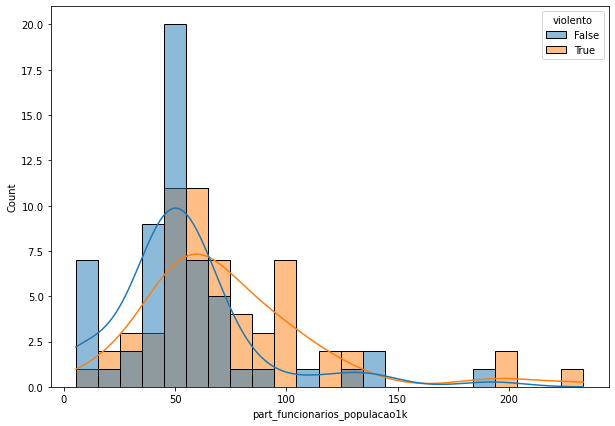

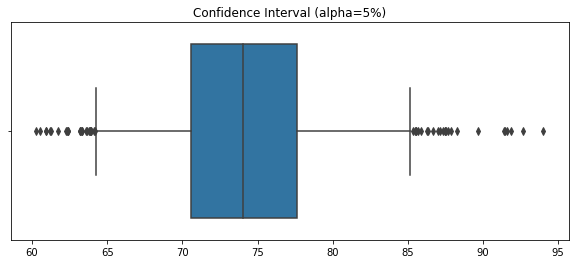

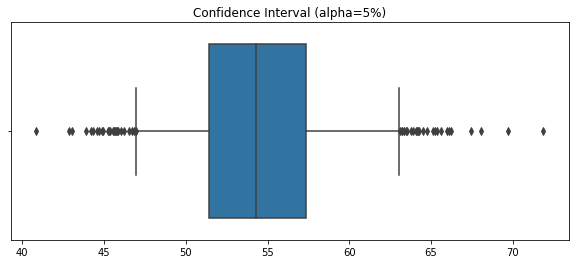

In [16]:
explainable_col = 'part_funcionarios_populacao1k'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença de empregabilidade entre cidades violentas e não violentas
- A empregabilidade em cidades mais violentas é maior (média de 74)
    - A cada mil habitantes entre 65-85 pessoas possuem emprego formal
- A empregabilidade em cidades menos violentas é menor (média de 54)
    - A cada mil habitantes entre 46-63 pessoas possuem emprego formal

**Existe diferença no PIB per capita entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 12364.152542372882
	CI (9912.046610169491, 15447.899152542372)
top_municipios_menos_violentos kpis:
	avg 11245.152542372882
	CI (8479.91059322034, 15453.092796610168)
KS-test KstestResult(statistic=0.2542372881355932, pvalue=0.04374463218775545)


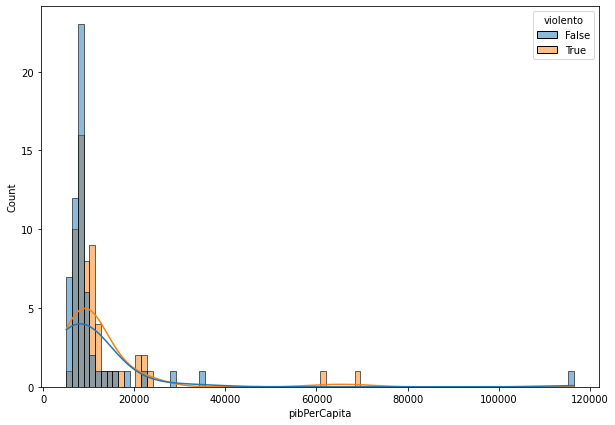

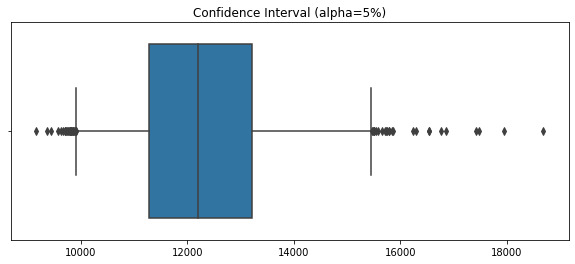

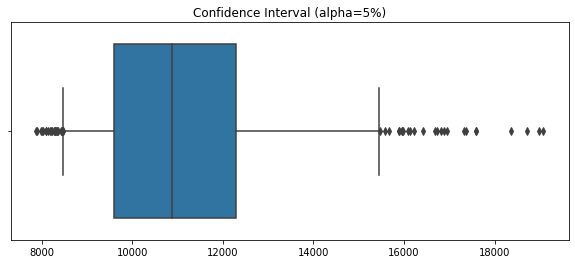

In [17]:
explainable_col = 'pibPerCapita'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe uma pequena diferença significante de PIB entre cidades mais/menos violentas
- O PIB em cidades mais violentas é maior (média de 12364)
    - A cada mil habitantes entre 65-85 pessoas possuem emprego formal
- O PIB em cidades menos violentas é menor (média de 11245)
    - A cada mil habitantes entre 46-63 pessoas possuem emprego formal

# Limitações

- Considera ano mais atual de cada base
- Considera faixa de populacao entre 0:10000
- Considera apenas municípios do Nordeste
- Considera apenas niveis de urbanização: alto, muito alto
- Considera apenas homicídios
- Considera apenas homicídios de Jovens (15 a 29 anos)

# Conclusion

- A relação entre cidades mais violentas com alta taxa de empregabilidade e nível menor de população parece ser contra-intuitivo 
- Em cidades mais violentas, as pessoas tendem a ser conhecer mais devido ao número menor da população
- Em cidades mais violentas, a população tem maior empregabilidade e, provavelmenente, mais poder de compra. Isso provavelmente chama a atenção de aproveitadores/bandidos, e, consequentemente, causar mais homicídios.
- TODO Precisamos investigar se as atividades econômicas de uma cidade influencia a violência (taxa de homicídios)
   - Quais as ocupacoes das pessoas que morreram?
   - Quais atividades economicas principais das cidades menos violentas?
   - Existe diferença de atividades economicas principais de cidades menos/mais violentas?
- TODO Outras análises também precisam ser feitas para cidades com outras faixas de população estimada
- TODO Análise global taxa de homícios nas cidades por faixa de popoulação
- OK analise correlacao
- TODO homicidios por racacor
- TODO homicidios por lococor
- TODO homicidios por nivel urbanizacao
- TODO homicidios por grupo de CID
- TODO homicidios por grupo de CBO
- TODO homicidios por grupo de CNAE
- TODO analisar dados do censo
- TODO dados mais recentes do PIB
- TODO dados mais recentes do população estimada

# Ações (TODO)

- Campanhas para fomentar empreendimentos com atividades econômicas mais relevantes para a cidade (Sebrae)
- Campanhas contra posse de arma
- Campanhas contra o racismo
- Campanhas contra o feminidicio
- Campanhas para fomentar a educação
- aumentar numero de hospitais